In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tqdm import tqdm
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
%matplotlib inline

In [3]:
from glob import glob

print('Files:')
for name in glob('/kaggle/input/breast-histopathology-images/10253/**/*.png'):
    print(name)

Files:
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1151_y401_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y601_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x2051_y1001_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x551_y751_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x2151_y1201_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1251_y451_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1051_y451_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1951_y951_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1401_y501_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y951_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x2101_y851_class0.png
/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x2151_

In [4]:
imagePatches = glob('/kaggle/input/breast-histopathology-images/10253/**/*.png', recursive=True)

In [5]:
import fnmatch
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)

In [6]:
y = []
for img in tqdm(imagePatches):
    if img in classZero:
        y.append(0)
    elif img in classOne:
        y.append(1)
images_df = pd.DataFrame()
images_df["labels"] = y
images_df["images"] = imagePatches
images_df.groupby("labels")["labels"].count()

100%|██████████| 549/549 [00:00<00:00, 92625.62it/s]


labels
0    479
1     70
Name: labels, dtype: int64

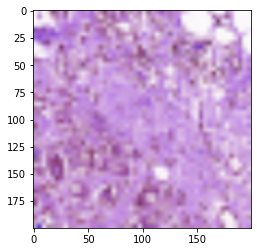

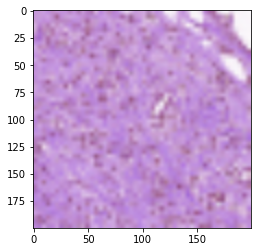

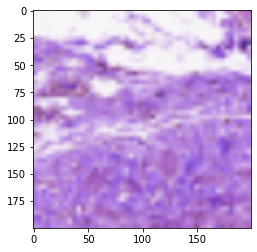

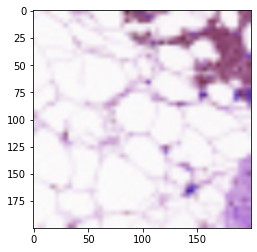

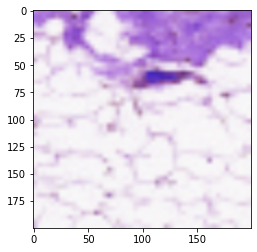

In [7]:
import cv2
import matplotlib.pyplot as plt
for i in imagePatches[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

Plot for Class distributions


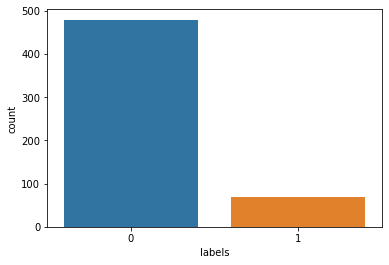

In [8]:
%matplotlib inline
print("Plot for Class distributions")

sns.countplot(images_df['labels'])

In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
describeData(images_df['images'],images_df['labels'])

Total number of images: 549
Number of IDC(-) Images: 479
Number of IDC(+) Images: 70
Percentage of positive images: 12.75%


In [10]:
images=[]
labels=[]
for i in imagePatches[:15000]:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)
print("Successfully Separated Features and Labels")

Successfully Separated Features and Labels


In [11]:
x=np.stack(images)
print("Stacked features into numpy.ndarray")

Stacked features into numpy.ndarray


In [12]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(labels)
print("Converted the target variable into one-hot-encoded variable")

Converted the target variable into one-hot-encoded variable


In [13]:
#normalize the data
x=x/255

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(x,y,random_state=0,test_size=0.2)
print("Splitted data into train(80%) and test(20%) set")

Splitted data into train(80%) and test(20%) set


In [15]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 



In [16]:
#create clients
print("Creating Clients...")
clients = create_clients(X_train, Y_train, num_clients=10, initial='client')
print("Total number of clients : 10")

Creating Clients...
Total number of clients : 10


In [17]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [18]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(len(Y_test))

In [18]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
def modelEfficientNetB0():
    
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = "imagenet",
                            input_shape=(100,100, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation = "sigmoid"))
    
    return model 
model = modelEfficientNetB0()
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [19]:
lr = 0.01 
comms_round = 3
loss='binary_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )    

In [20]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print("Federated-Round : ", comm_round)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [21]:
import time

#initialize global model
smlp_global = model
global_model = smlp_global
        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = model
        local_model = smlp_local
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    tic = time.time()
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
    toc = time.time()
    
    print("Time elapsed : ", toc-tic)

Federated-Round :  0
comm_round: 0 | global_acc: 12.727% | global_loss: 0.7536149024963379
Time elapsed :  1.5986602306365967
Federated-Round :  1
comm_round: 1 | global_acc: 12.727% | global_loss: 0.8159946203231812
Time elapsed :  1.5159697532653809
Federated-Round :  2
comm_round: 2 | global_acc: 12.727% | global_loss: 0.8442453742027283
Time elapsed :  1.2859492301940918


In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
test_model(X_test, Y_test, model, 10)